#**Sentiment Analysis**

Sentiment analysis tries to capture subjective aspects in texts,
e.g., whether a tweet on Twitter shows a positive or negative mood of the author. Sentiment analysis is a text classification problem.
The difference to topic identification is that in sentiment analysis, we do not want to classify our documents by objective aspects (e.g., by
topics) but to get an idea of the subjective aspects in the text (e.g., positive or negative
feedback) [[1]](#scrollTo=P4arl7P3xUuB).

This notebook shows examples of sentiment analysis with ``simpletransformers`` [[2]](https://simpletransformers.ai/about/).


## **Sentiment analysis with ``simpletransformers``**

In this section, We show how to train and evaluate our own sentiment analysis model using the ``simpletransformers`` library and the Stanford’s large movie review dataset [[3]](https://ai.stanford.edu/~amaas/data/sentiment/).



This dataset contains 50,000 annotated movie reviews: 25,000 reviews in the training set
and another 25,000 reviews in the test set. Each review consists of text data including
HTML tags for line breaks and a label that can be either “positive” or “negative.” The
data is extracted from IMDb. IMDb uses a scoring system for the reviews. If the score is
less than or equal to 4 out of 10, a review is labeled “negative”; scores greater than or
equal to 7 are labeled “positive.” Reviews that receive between 4 and 7 points are considered neutral and not included in the dataset [[1]](#scrollTo=P4arl7P3xUuB).



We perform the following steps:
* Install the ``simpletransformers`` library
* Import other libraries and packages; ``pandas``, ``ClassificationModel``, ``train_test_split``and ``preprocessing``
* Download dataset from Kaggle
* Create a general classification model
* Fine-tune the general model
* Evaluate the fine-tuned model
* Make predictions for a given text

### Install ``simpletransformers``

First, we install the ``simpletransformers`` library. This library is based on the Hugging Face transformers library [[4]](https://huggingface.co/docs/transformers/index). ``simpletransformers`` helps us to quickly train and evaluate transformer models. For more details about the ``simpletransformers`` library, please refer to [[2]](https://simpletransformers.ai/about/).


In this notebook, we use the following functions of the ``simpletransformers``library:
* ``ClassificationModel()`` to create a general classification model
* ``train_model()`` to fine-tune the general model
* ``eval_model()`` to evaluate the fine-tuned model
* ``predict()`` to make predictions for a given text



**Note:**<br>
Deep Learning (DL) models typically run on CUDA-enabled GPUs as the performance is better compared to running on a CPU [[5]](https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda). CUDA is a parallel computing platform created by NVIDIA.

On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, we should enable CUDA in our GPU. If we use Google Colab, we do not need to do anything since CUDA is pre-installed. But we need to enable the GPU in our Colab top menu by clicking on "Runtime/Change runtime type" and choosing "GPU".
 
In order to proceed without CUDA, we run the following code snippets until we can disable CUDA in ["Create classification model"](#scrollTo=DmfjRTC21KCt).

In [1]:
# Install the simpletransformers library
# Important: If you see a button "RESTART RUNTIME" after installing simpletransformers, click on this button to restart the runtime.
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 14.2 MB/s 
     |████████████████████████████████| 6.6 MB 62.8 MB/s 
     |████████████████████████████████| 362 kB 74.7 MB/s 
     |████████████████████████████████| 1.8 MB 67.5 MB/s 
     |████████████████████████████████| 9.1 MB 54.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 56.1 MB/s 
     |████████████████████████████████| 4.4 MB 56.9 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
     |████████████████████████████████| 181 kB 64.4 MB/s 
     |████████████████████████████████| 153 kB 41.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 140 kB 26.0 MB/s 
     |████████████████████████████████| 212 kB 35.4 MB/s 
     |██████████████████████████████

### Import libraries and packages

### Import libraries and packages
We import all necessary libraries: In addition to ``simpletransformers``,
we need functions from ``sklearn`` and ``pandas`` to process our dataset. For more details about the ``sklearn`` and ``pandas`` libraries, please refer to [[6]](https://scikit-learn.org/stable/) and [[7]](https://pandas.pydata.org/).


In [1]:
# Import the pandas library
import pandas as pd

# Import the "ClassificationModel" package for text classification tasks
from simpletransformers.classification import ClassificationModel

# Import the "train_test_split" function from the sklearn library
from sklearn.model_selection import train_test_split

# Import the "preprocessing" package from sklearn
from sklearn import preprocessing

# Import pyplot from matplotlib library to plot label distribution
from matplotlib import pyplot as plt

# import the 're' module to remove the HTML-tags during the data cleaning step
import re


### Download dataset

#### 1- Create folder
We create a Kaggle folder in Colab to download dataset from [https://ai.stanford.edu](https://ai.stanford.edu/~amaas/data/sentiment/)

In [38]:
# Prepare folders in the colab environment
import os

os.mkdir('/content/data')

FileExistsError: ignored

In [4]:
# Change current directory
os.chdir('/content/data')

#### 2- Download and unpack dataset

Since the dataset ``aclImdb_v1.tar.gz`` is compressed in zip format, we download and extract it.

In [5]:
# Download dataset
!curl -O --location https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9597k      0  0:00:08  0:00:08 --:--:-- 17.9M


In [6]:
 # Extract dataset
!tar -xf aclImdb_v1.tar.gz

In [7]:
# Get back to default ('content/') location
os.chdir('..')

### Data preparation
As explained before, our dataset contains 50,000 movie reviews. It is divided evenly into 25.000 reviews for training set and 25.000 reviews for testing set . The labels are balanced between the two classes (positive and negative). That means, we have 12.500 positive reviews and 12.500 negative reviews for each set.

If we check the downloaded dataset, we see that each review is a seperate ``txt`` file. The positive reviews are located in the ``pos`` folder and negative reviews are located in the ``neg`` folder. 

For our classification model, we should combine all positive and negative review files into 1 pandas DataFrame representing the train dataset. We do the same process for test dataset.

#### Define a function to combine ``txt`` files
We create a function to add all ``txt`` files into one list for the given ``file_folder``.

This function creates returns 2 lists, ``labels`` and ``data``. The list ``labels`` contains the labels of review, ``0`` for negative and ``1`` for positive sentiments. The list ``data`` contains all reviews as ``str``(string).

In [2]:
# Define a function to add all single text-file contents into one list
def get_appendedData(file_folder):
  labels, data = [], []

  for label in ('neg', 'pos'):
    folder_name = os.path.join(file_folder, label)
    
    for file in os.listdir(folder_name):
      with open(os.path.join(folder_name, file), 'rb') as f:

        review = f.read().decode('utf-8').replace('\n', '')
        data.append(review)
        labels.append(1 if label == 'pos'else 0)

  return labels, data

#### Create train and test sets

In [22]:
train_folder = '/content/data/aclImdb/train'
test_folder = '/content/data/aclImdb/test'

train_data = get_appendedData(train_folder)
test_data = get_appendedData(test_folder)

In [23]:
train_df = pd.DataFrame(train_data).transpose()
train_df.columns = ['review', 'label']

test_df = pd.DataFrame(test_data).transpose()
test_df.columns = ['review', 'label']

#### Check content of datasets
We have created the test and training sets. However, before we proceed, we should check the content of the datasets and decide if they contain any unwanted data.

##### Print first 3 rows
First we print the first 3 reviews of the train and test datasets with the ``head()`` function.

In [24]:
train_df.head(3)

,review,label
0,I got this as a turkey movie and was I not dis...,0
1,While I have never been a fan of the original ...,0
2,"When a friend gave me a boxed set of ""12 Amazi...",0


In [26]:
test_df.head(3)

,review,label
0,"After the turning point of NIGHT MUST FALL, Ro...",0
1,"""Tart"" is a good illustration of old the Yogi ...",0
2,"If I had never seen the first Road House, then...",0


##### Visualize label distribution

We should have 12500 positive and 12500 negative reviews for each dataset. We plot the label distribution with the ``matplotlib`` library.

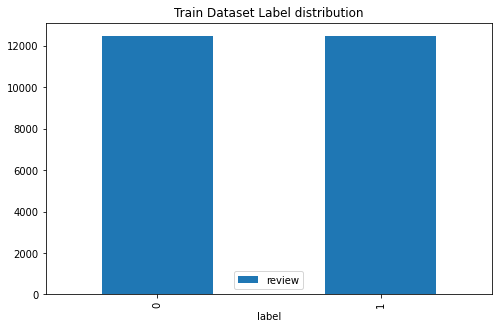

In [28]:
# Plot a bar chart and display label distribution of the train dataset
ax = train_df.groupby("label").count().plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Train Dataset Label distribution")
plt.show()

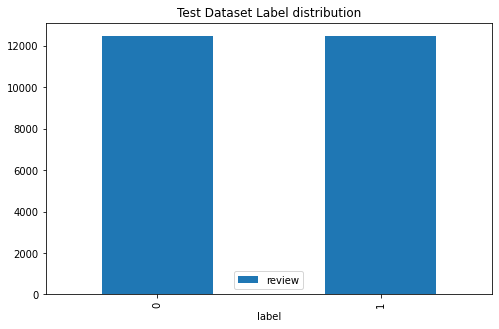

In [29]:
# Plot a bar chart and display label distribution of the test dataset
ax = test_df.groupby("label").count().plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Test Dataset Label distribution")
plt.show()

##### Check content of reviews

We have not seen any problem so far. Now we print a review and check its content to decide if it contains any unwanted data.

In [31]:
# Print the first review of the train dataset
print(train_df["review"][0])

I got this as a turkey movie and was I not disappointed.<br /><br />Acting - overall even though many have been in other movies it is clear that they had to work hard to act this bad so constantly over this entire movie with out accidentally letting slip some degree of acting.<br /><br />Plot - being generous I could say that the scriptwriter did originally start with a plot but but did his best to ignore it. the plot broke down faster then a Chinese knock off computer <br /><br />Scrip - now that was an abomination of nature. it failed to flow with any rhyme or reason. the majority of the lines by the characters were at best pathetic to imbecilic. the script worked hard to make sure that no character managed to get to be considered memorable. I have watched other movies where the extras were more interesting and memorable.<br /><br />Special effects - ROTFLMAO!!!!! They were short bus special <br /><br />Directing - until you can come up with your own directing ability copy the style 

In [32]:
# Print the first review of the test dataset
print(test_df["review"][0])

After the turning point of NIGHT MUST FALL, Robert Montgomery (for the most time) came into his finest films and performances: HERE COMES MR. JORDAN, THEY WERE EXPENDABLE, THE LADY IN THE LAKE, RIDE THE PINK HORSE, THE SAXON CHARM, JUNE BRIDE. Even some of the failures he was in were interesting enough to be still watchable (RAGE IN HEAVEN, MR. AND MRS. SMITH). But Montgomery wanted to do more and more production and directing work. In 1949 he made what would be his last movie performance - he played Collier Lang, an egotistical movie star, who is dragged into helping the authorities do an investigation about a young girl's boyfriend.<br /><br />Apparently my view of this film is a minority view. Most of the views given are favorable about it. I thought it was a dull, witless script, with Ann Blyth's groupie heroine not very appealing as a character. She admires Montgomery as a star, and this "helps" when he is called in to assist the authorities, but after awhile I found there was no 

As we see above, there are HTML-tags inside the reviews. These tags are irrelevant for our task and we should delete them to improve the performance of our classification model. 

#### Data Cleaning

In this step, we remove the HTML-tags from our datasets. For this, we use the ``re.compile()`` function of the ``re`` module. The ``re`` module is a built-in python package and  it provides a set of powerful regular expression facilities, which allows us to quickly check whether a given string matches a given pattern or contains such a pattern.
The following code is based on [[3]](https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string).

In [33]:
# Define and compile regular expressions to match HTML-tags
cleanhtml_re = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
cleanbrackets_re = re.compile('\[[^]]*\]')
cleanspecchar_re = re.compile(r'[^a-zA-z0-9\s]')

# Define a function which takes a raw text as input and returns it without HTML-tags as "cleantext"
def cleanhtml(raw_text):
  cleantext = re.sub(cleanhtml_re, '', raw_text)
  cleantext = re.sub(cleanbrackets_re,'', cleantext)
  cleantext = re.sub(cleanspecchar_re, '', cleantext)

  return cleantext


# def cleanbrackets(raw_text):
#   cleantext = re.sub(cleanbrackets_re,'', raw_text)
#   return cleantext


# def cleanspecchar(raw_text):
#   cleantext = re.sub(cleanspecchar_re, '', raw_text)
#   return cleantext

In [34]:
# Remove HTML tags in training data

train_df['review'] = train_df['review'].apply(cleanhtml)

In [35]:
# Print the first review of the train dataset
print(train_df["review"][0])

I got this as a turkey movie and was I not disappointedActing  overall even though many have been in other movies it is clear that they had to work hard to act this bad so constantly over this entire movie with out accidentally letting slip some degree of actingPlot  being generous I could say that the scriptwriter did originally start with a plot but but did his best to ignore it the plot broke down faster then a Chinese knock off computer Scrip  now that was an abomination of nature it failed to flow with any rhyme or reason the majority of the lines by the characters were at best pathetic to imbecilic the script worked hard to make sure that no character managed to get to be considered memorable I have watched other movies where the extras were more interesting and memorableSpecial effects  ROTFLMAO They were short bus special Directing  until you can come up with your own directing ability copy the style of your favorite directer otherwise you will only make failures like thisIt is

In [14]:
# Remove brackets in training data

#train_df['review'] = train_df['review'].apply(cleanbrackets)

In [15]:
# Remove special characters in training data

#train_df['review'] = train_df['review'].apply(cleanspecchar)

### Create classification model

Now, we create our classification model. We use the ``bert_base_uncased`` model from the ``bert`` model family. The number of labels (categories) is set to 2 as we want to differ positive and negative reviews.

**NOTE:** 
On all ``simpletransformers`` models, CUDA is enabled by default which is recommended. If a system is not able to operate with CUDA, we can disable it. Below we find code for both options.

Option-1: With CUDA (Recommended)

In [36]:
# Create a classification model
## We will use 'bert' classification model
## We choose "uncased" (lowercase) bert model
## num_labels specifies he number of labels or classes in the dataset

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Option-2: Without CUDA


In [ ]:
# Run this code to only disable CUDA:

#model = ClassificationModel('bert',
#                            'bert-base-uncased',
#                            num_labels=len(labels),
#                            use_cuda=False))

### Train model

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters, and preprocesses our training data using a
subword tokenizer before the actual training process is started [[1]](#scrollTo=P4arl7P3xUuB).

In [37]:
# Train the model
model.train_model(train_df)

ValueError: ignored

### Evaluation

We evaluate the model by using our evaluation set.

In [18]:
# Evaluate the model
result, model_outputs, predictions = model.eval_model(test_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/25000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3125 [00:00<?, ?it/s]

In [19]:
print(result)

{'mcc': 0.7464023874853244, 'tp': 11360, 'tn': 10445, 'fp': 2055, 'fn': 1140, 'auroc': 0.9478939584000001, 'auprc': 0.9458387286491584, 'eval_loss': 0.3258090441131592}


# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda
- [3] https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string


Copyright © 2022 IU International University of Applied Sciences